In [1]:
### fix how M values is taken in
### Switch to Jupyter Notebook
### Import Data
### Make a special data file with only 10 events or so
### Plot the raw signals from those 10 events
### Plot resulting Trapezoids
#XX figure out calibration
#XX Plot the full, calibrated energy spectra for Co, Cs, Am (to check for re-takes)
### Fit peaks and get FWHM Values
### Plot FWHM vs gap time
### Plot FWHM vs peak time
### Set optimal peak and gap times and save spectrum
### Make electronic noise plot
# noise contributions fitting/ modeling
# calculate FANO factor
# Write text
# Write TEST functions
# check fano calc and check fano in knoll. ~0.12
# MAKE SHORTER NOTEBOOK FOR SAMPLE

# CITE LMFIT
# ADD PRECISE ENERGIES AND CITE NNDC

In [49]:
%run ./lab1_analysis_functions.py

In [3]:
tenevents = read_ten_event_file()

M = find_M_value(tenevents)
print('M ', M)

('M ', 4445.9118105773478)


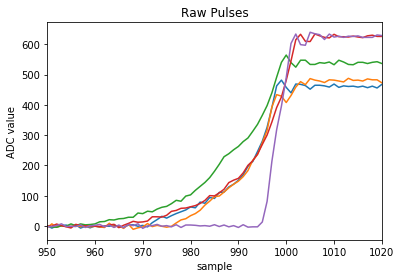

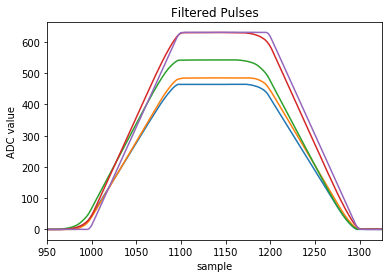

In [4]:
tenevents = read_ten_event_file()
ndata = len(tenevents)
nsamples = 4096
x_values = np.linspace(0, nsamples, nsamples)
tenevents = fast_baseline_correction(tenevents)
plt.figure()
plt.cla()
plt.clf()
for event in tenevents[0:5]:
    plt.plot(event)
plt.xlim([950, 1020])
plt.title('Raw Pulses')
plt.ylabel('ADC value')
plt.xlabel('sample')
plt.savefig('../figures/tenevents_rawdata.pdf')
plt.show()

k = 100
m = 100

plt.figure()
plt.cla()
plt.clf()
for event in tenevents[0:5]:
    event = fast_trapezoidal_filter(event, k, m, M=4400)
    plt.plot(x_values, event)
plt.xlim([950, 1325])
plt.title('Filtered Pulses')
plt.ylabel('ADC value')
plt.xlabel('sample')
plt.savefig('../figures/tenevents_filtered.pdf')
plt.show()

In [5]:
filename = '../data/Am_pulser_real.h5'
am_raw_data = import_data(filename)

filename = '../data/Cs_pulser_real.h5'
cs_raw_data = import_data(filename)

filename = '../data/Co_pulser_real.h5'
co_raw_data = import_data(filename)

In [6]:
co_baseline = np.mean(co_raw_data[:len(co_raw_data),0:799],1).reshape((len(co_raw_data),1))
co_baseline_corrected_signals = co_raw_data[:len(co_raw_data),] - co_baseline

In [10]:
# M = find_M_value(cs_baseline_corrected_signals[0:len(co_raw_data)])
M = 5920.5649833
optimal_M = M
print('optimal M: ', M)

('optimal M: ', 5920.5649833)


In [11]:
# OPTIMIZE GAP TIME

m_values = np.linspace(0, 100, 20)
k = 100

number_of_events = len(co_raw_data)
# number_of_events = 10000
assert number_of_events <= len(co_raw_data)
ndata = 4096

m_fwhm_values = []
m_values_ns = []
m_fwhm_values_err = []

for m in m_values:
    m = int(m)
    m_values_ns.append(m * 10)
    
    co_nrgs=[]
    co_nrgs = np.apply_along_axis(fast_trapezoidal_filter_energy, 1, co_baseline_corrected_signals, k, m, M)
    nbins = 2048
    co_counts, bin_edges = np.histogram(co_nrgs, bins=2048, range=[0, 2048]) #, range=Cs_range) # WORKS
    co_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
    co_fwhm, co_center, err = fit_gaussian_peak_linear_background(co_bins[550:690], co_counts[550:690])
    m_fwhm_values_err.append(err)
    m_fwhm_values.append(round(co_fwhm / co_center, 7) * 100)


In [12]:
optimal_gap_time =  int(m_values_ns[np.argmin(m_fwhm_values)]) / 10
m = optimal_gap_time 
print('optimal gap time: ' + str(m * 10))

optimal gap time: 420


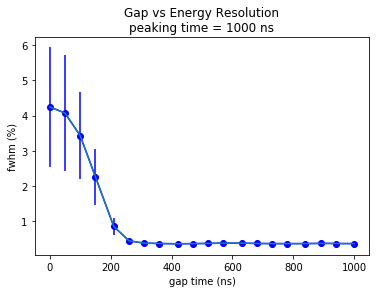

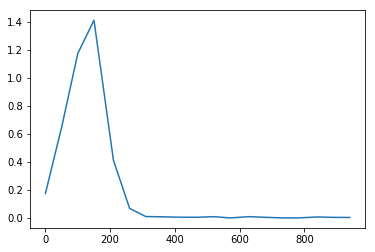

In [13]:
plt.figure()
plt.cla()
plt.clf()
plt.xlabel('gap time (ns)')
plt.ylabel('fwhm (%)')
plt.errorbar(m_values_ns, m_fwhm_values, yerr=m_fwhm_values_err, ecolor='b')
plt.plot(m_values_ns, m_fwhm_values, 'o-b')
plt.title('Gap vs Energy Resolution' + '\n'  + 'peaking time = ' + str(k * 10) + ' ns')
plt.savefig('../figures/gap_optimization_co.pdf')
plt.show()

plt.figure()
plt.cla()
plt.clf()
m_diff_list = abs(np.diff(m_fwhm_values))
plt.plot(m_values_ns[0:-1], m_diff_list, '-')
plt.show()

In [14]:
optimal_gap_time =  int(m_values_ns[np.argmin(m_fwhm_values)]) / 10
m = optimal_gap_time 
print('optimal gap time: ' + str(m * 10))

optimal gap time: 420


In [15]:
# OPTIMIZE PEAKING TIME

k_values = np.logspace(np.log10(10), np.log10(2000), 30, endpoint=True, base=10)
number_of_events = len(co_raw_data)
assert number_of_events <= len(co_raw_data)

k_fwhm_values = []
k_fwhm_values_err = []
k_fwhm_pulser_values = []
k_values_ns = []

nbins = 2048

for k in k_values:
    k = int(k)
    k_values_ns.append(k * 10)
    
    co_nrgs=[]
    co_nrgs = np.apply_along_axis(fast_trapezoidal_filter_energy, 1, co_baseline_corrected_signals, k, m, M)
    co_counts, bin_edges = np.histogram(co_nrgs, bins=2048, range=[0, 1024]) #Cs_range) # WORKS
    co_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
    
    peak_fwhm, peak_center, err =fit_gaussian_peak_linear_background(co_bins[1200:1450], co_counts[1200:1450]) #, max(cs_counts), np.argmax(cs_counts), 1)
    k_fwhm_values.append(round(peak_fwhm / peak_center, 7) * 100)
    k_fwhm_values_err.append(err)


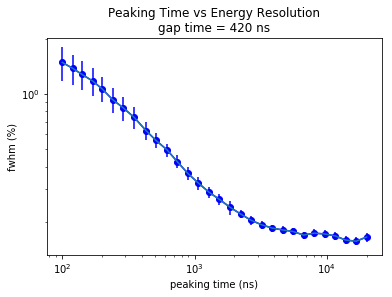

In [16]:
plt.figure()
plt.cla()
plt.clf()
plt.xlabel('peaking time (ns)')
plt.ylabel('fwhm (%)')
plt.errorbar(k_values_ns, k_fwhm_values, yerr=k_fwhm_values_err, ecolor='b')
plt.loglog(k_values_ns, k_fwhm_values, 'o-b')
plt.title('Peaking Time vs Energy Resolution' + '\n'  + 'gap time = ' + str(m * 10) +' ns')
plt.savefig('../figures/peak_optimization_co.pdf')
plt.show()

In [17]:
optimal_peaking_time = k_values_ns[np.argmin(k_fwhm_values)] / 10
# k = 50
k = optimal_peaking_time
print('optimal peaking time: ', k)

('optimal peaking time: ', 1666)


In [21]:
# Final Filter Paramters
print("========  Final Filter Parameters  ========")
print(' gap time (m)     = ' + str(m * 10) + ' ns')
print(' peaking time (k) = ' + str(k * 10) + ' ns')
print(' decay time (M)   = ' + str(round(M / 10,2)) + ' ns')
print("===========================================")

save_parameters(m * 10 , k * 10 , M / 10)

========  Final Filter Parameters  ========
 gap time (m)     = 420 ns
 peaking time (k) = 16660 ns
 decay time (M)   = 592.06 ns


In [22]:
cs_baseline = np.mean(cs_raw_data[:len(cs_raw_data),0:799],1).reshape((len(cs_raw_data),1))
cs_baseline_corrected_signals = cs_raw_data[:len(cs_raw_data),] - cs_baseline

am_baseline = np.mean(am_raw_data[:len(am_raw_data),0:799],1).reshape((len(am_raw_data),1))
am_baseline_corrected_signals = am_raw_data[:len(am_raw_data),] - am_baseline

# co_baseline = np.mean(co_raw_data[:len(co_raw_data),0:799],1).reshape((len(co_raw_data),1))
# co_baseline_corrected_signals = co_raw_data[:len(co_raw_data),] - co_baseline

cs_nrgs = np.apply_along_axis(fast_trapezoidal_filter_energy, 1, cs_baseline_corrected_signals, k, m, M)
co_nrgs = np.apply_along_axis(fast_trapezoidal_filter_energy, 1, co_baseline_corrected_signals, k, m, M)
am_nrgs = np.apply_along_axis(fast_trapezoidal_filter_energy, 1, am_baseline_corrected_signals, k, m, M)

In [29]:
# make_nrg_sample_file(co_nrgs[0:len(co_nrgs)], './data/co_energies.txt')
# make_nrg_sample_file(co_nrgs[0:len(cs_nrgs)], './data/cs_energies.txt')
# make_nrg_sample_file(co_nrgs[0:len(am_nrgs)], './data/am_energies.txt')

In [40]:
# GET ENERGY RESOLUTION FOR DIFFERENT PEAKS

fwhm_peak_values = []
fwhm_peak_energies = []
fwhm_pulser_values = []
peak_err = []
pulser_err = []

# AM-241
am_counts, bin_edges = np.histogram(am_nrgs, bins=2048, range=[0, 400])
am_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
am_bins = am_bins[10:250] 
am_counts = am_counts[10:250]
peak_fwhm, peak_center ,err = fit_gaussian_peak_linear_background(am_bins, am_counts)
fwhm_peak_values.append(round(peak_fwhm / peak_center, 7) * 100)
fwhm_peak_energies.append(59.536)
peak_err.append(err)

# AM-PULSER

am_counts, bin_edges = np.histogram(am_nrgs, bins=2048, range=[0, 400])
am_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
am_bins = am_bins[1000:2000] 
am_counts = am_counts[1000:2000]
pulser_fwhm, pulser_center ,err = fit_gaussian_peak_linear_background(am_bins, am_counts)
fwhm_pulser_values.append(round(pulser_fwhm / pulser_center, 7) * 100)
pulser_err.append(err)

# CS-662
cs_counts, bin_edges = np.histogram(cs_nrgs, bins=2048, range=[0, 512])
cs_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
cs_bins = cs_bins[1000:2000]
cs_counts = cs_counts[1000:2000]
cs_peak_fwhm, cs_peak_center, err = fit_gaussian_peak_linear_background(cs_bins, cs_counts)

fwhm_peak_values.append(round(cs_peak_fwhm / cs_peak_center, 7) * 100)
fwhm_peak_energies.append(661.615)
peak_err.append(err)

# CS-PULSER
cs_counts, bin_edges = np.histogram(cs_nrgs, bins=2048, range=[900, 900+512])
cs_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
cs_bins = cs_bins[100:1000]
cs_counts = cs_counts[100:1000]
cs_pulser_fwhm, cs_pulser_center, err = fit_gaussian_peak_linear_background(cs_bins, cs_counts)
fwhm_pulser_values.append(round(cs_pulser_fwhm / cs_pulser_center, 7) * 100)
pulser_err.append(err * 100 / cs_pulser_center)

# CO-1173
co_counts, bin_edges = np.histogram(co_nrgs, bins=2048, range=[0, 1024])
co_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
peak_1_fwhm, peak_1_center, err = fit_gaussian_peak_linear_background(co_bins[1200:1450], co_counts[1200:1450])
fwhm_peak_values.append(round(peak_1_fwhm / peak_1_center, 7) * 100)
fwhm_peak_energies.append(1173.231)
peak_err.append(err * 100 / peak_1_center)

# CO-1332
co_counts, bin_edges = np.histogram(co_nrgs, bins=2048, range=[0, 1024])
co_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
co_bins = co_bins[1400:1600]
co_counts = co_counts[1400:1600]
peak_2_fwhm, peak_2_center,err = fit_gaussian_peak_linear_background(co_bins, co_counts)
fwhm_peak_values.append(round(peak_2_fwhm / peak_2_center, 7) * 100)
fwhm_peak_energies.append(1332.508)
peak_err.append(err * 100/ peak_2_center)

# CO-PULSER
co_counts, bin_edges = np.histogram(co_nrgs, bins=2048, range=[512, 1024])
co_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
co_bins = co_bins[1800:] 
co_counts = co_counts[1800:]
pulser_fwhm, pulser_center,err = fit_gaussian_peak_linear_background(co_bins, co_counts)
fwhm_pulser_values.append(round(pulser_fwhm / pulser_center, 7) * 100)
pulser_err.append(err * 100/ pulser_center)

In [38]:
%run ./lab1_analysis_functions.py

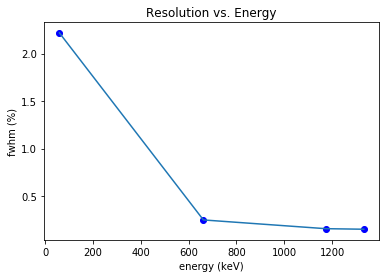

In [47]:
plt.plot(fwhm_peak_energies, fwhm_peak_values, 'ob')
plt.errorbar(fwhm_peak_energies, fwhm_peak_values, yerr=peak_err, ecolor='b')
plt.title('Resolution vs. Energy')
plt.ylabel('fwhm (%)')
plt.xlabel('energy (keV)')
plt.savefig('../figures/fwhm_vs_energy.pdf')
plt.show()

In [54]:
# find fano factor

fano_list = []
fwhm_elec = np.mean(fwhm_pulser_values[-2:-1]) # Am-241 pulser value is very differnet. Shouldn't depend on energy. Ignore for now.
for i in range(0, len(fwhm_peak_energies), 1):
    e = fwhm_peak_energies[i]
    fwhm =(fwhm_peak_values[i] / 100) # was a percent
    fwhm = fwhm - (fwhm_elec / 100)
    fwhm = fwhm * fwhm_peak_energies[i] #fwhm in kev
    fano =fwhm * (1/2.35) * np.sqrt(1/(e*(2.9*10**(-3)))) 
    fano = fano**2
    fano = round(fano, 3)
    fano_list.append(fano)
    
fano = round(np.mean(fano_list[1:]),3)
print('average fano factor: ', fano)
print(fano_list)

pulser_err=np.mean(pulser_err)
peak_err=np.mean(peak_err)
err_tot = np.sqrt((pulser_err/100)**2 + (peak_err/100)**2)
save_fano(fano, err)

('average fano factor: ', 0.094)
[1.731, 0.146, 0.068, 0.068]
